<div style="text-align: center;">
    <img src="https://user-images.githubusercontent.com/86345471/221379942-51f24819-1f76-4289-8dee-06ea69f730f6.png" alt="Main KPI" />
</di>

<hr>

<hr>

**Завдання:** Знайти якісний англомовний датасет із понад 10 000 записами, який містить мітки для задачі виявлення політичної пропаганди або бот-активності в соцмережах (X, Facebook, Telegram), і використати будь-який метод машинного навчання для дослідження інформації та створення моделі даних.

**Передмова:** Для дослідження було обрано англомовний датасет <u>Twitter Human-Bots</u> (з Hugging Face Datasets), що містить ≈37 400 записів профілів Twitter із позначками ‘bot’ або ‘human’. Кожен запис – це обліковий запис користувача з різними атрибутами (ID, кількість підписників/друзів, кількість твітів тощо) та полем **account_type** (мітка ‘bot’ чи ‘human’). Датасет має близько 20 полів (наприклад, id, created_at, default_profile, followers_count, friends_count, statuses_count, verified, average_tweets_per_day, account_age_days, account_type тощо) і два класи у форматі рядків (“bot”/“human”). Також датасет доступний для завантаження у вигляді CSV-файлу (розмір ≈11.8 МБ) – наприклад, з Hugging Face або Kaggle. На Hugging Face у розділі “Files” наведено файл <u>twitter_human_bots_dataset.csv</u>

<hr>

<hr>

### ♻️ 0. Переформатування даних під WEKA

In [1]:
import arff
import pandas as pd

# • Прибираємо перший порожній стовпець
df = pd.read_csv("hf://datasets/airt-ml/twitter-human-bots/twitter_human_bots_dataset.csv")
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# • Друкуємо інформацію про датасет
print("\n===== INFO =====")
df.info()
print("\n=== DESCRIBE ===")
print(df.describe())
print("\n==== SAMPLE ====")
print(df.sample(5))

# • Готуємо атрибути для ARFF
attributes = []
for col in df.columns:
    dtype = df[col].dtype
    if pd.api.types.is_integer_dtype(dtype) or pd.api.types.is_float_dtype(dtype):
        arff_type = "NUMERIC"
    elif pd.api.types.is_bool_dtype(dtype):
        arff_type = ["False", "True"]
    else:
        arff_type = "STRING"
    if col == "account_type":
        arff_type = sorted(df[col].dropna().unique().tolist())
    attributes.append((col, arff_type))

# • Формуємо ARFF-структуру
arff_data = {
    "description": "Twitter Human vs Bot Dataset",
    "relation": "twitter_human_bots",
    "attributes": attributes,
    "data": df.values.tolist()
}

# • Записуємо у ARFF та CSV
with open("./twitter-human-bots/twitter_human_bots_dataset.arff", "w", encoding="utf-8") as fn:
    arff.dump(arff_data, fn)
print("\n\nSaved ARFF to twitter_human_bots_dataset.arff")

df.to_csv("./twitter-human-bots/twitter_human_bots_dataset-clean.csv", index=False, encoding="utf-8")
print("\n\nSaved CSV to twitter_human_bots_dataset_clean.csv")


===== INFO =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37438 entries, 0 to 37437
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   created_at                    37438 non-null  object 
 1   default_profile               37438 non-null  bool   
 2   default_profile_image         37438 non-null  bool   
 3   description                   30182 non-null  object 
 4   favourites_count              37438 non-null  int64  
 5   followers_count               37438 non-null  int64  
 6   friends_count                 37438 non-null  int64  
 7   geo_enabled                   37438 non-null  bool   
 8   id                            37438 non-null  int64  
 9   lang                          29481 non-null  object 
 10  location                      37435 non-null  object 
 11  profile_background_image_url  32939 non-null  object 
 12  profile_image_url             37437 non-nu

<hr>

### 🌐 1. Завантаження і первинна обробка даних

In [2]:
import pandas as pd

df = pd.read_csv("./twitter-human-bots/twitter_human_bots_dataset-clean.csv")
print("Shape of dataset:", df.shape, "\n")

# Перевірка на пропущені значення
print(df.isnull().sum(), "\n")

# Перетворимо класову мітку на числову
df['label'] = df['account_type'].map({'human': 0, 'bot': 1})
print(df['label'].value_counts())

Shape of dataset: (37438, 19) 

created_at                         0
default_profile                    0
default_profile_image              0
description                     7256
favourites_count                   0
followers_count                    0
friends_count                      0
geo_enabled                        0
id                                 0
lang                            7957
location                           3
profile_background_image_url    4499
profile_image_url                  1
screen_name                        0
statuses_count                     0
verified                           0
average_tweets_per_day             0
account_age_days                   0
account_type                       0
dtype: int64 

0    25013
1    12425
Name: label, dtype: int64


<hr>

### 📊 2. Візуалізація залежностей між атрибутами

<div style="text-align: center;">
    <img src="D:\KPI\5%20курс%20Магістрат\Web%20-%20аналітика\twitter-human-bots\class_distribution.png" alt="Main View" />
</di>

<div style="text-align: center;">
    <img src="file:///D:/KPI/5%20курс%20Магістрат/Web%20-%20аналітика/twitter-human-bots/class_distribution.png" alt="Main View" />
</di>

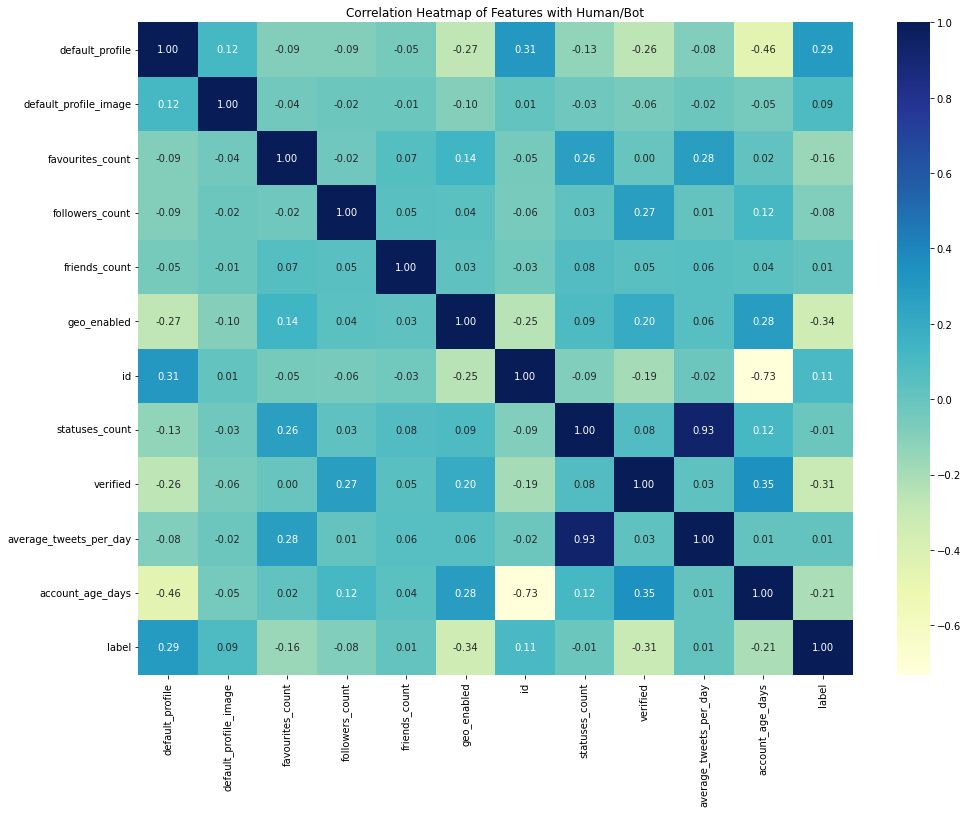

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f')

plt.title('Correlation Heatmap of Features with Human/Bot')
plt.show()

<hr>

### 🗃️ 3. Поділ на тренувальний і тестовий набори

In [4]:
from sklearn.model_selection import train_test_split

# Вибір ознак для задачі моделювання (числові поля)
features = ['favourites_count', 'followers_count', 'friends_count', 'statuses_count', 
            'verified', 'average_tweets_per_day', 'account_age_days', 
            'default_profile', 'default_profile_image', 'geo_enabled']

X = df[features]
y = df['label']  # Цільова метрика "account_type"

# Розбиваємо на тренувальний та тестовий (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Train Shape: {X_train.shape}\n"
      f"& Test Shape: {X_test.shape}\n")

Train Shape: (28078, 10)
& Test Shape: (9360, 10)



<div style="text-align: center;">
    <img src="./twitter-human-bots/obtained_dataset.png" alt="Main View" />
</di>

<hr>

### 🤖 4. Побудова простої ML-моделі

In [5]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

<div style="text-align: center;">
    <img src="./twitter-human-bots/started_training.png" alt="Main Train" />
</di>

<hr>

### 📝 5. Оцінка точності моделі

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")
print(f"\nPrecision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"\nConfusion Matrix:\n{cm}")

Accuracy: 0.878

Precision: 0.855
Recall: 0.762

Confusion Matrix:
[[5852  402]
 [ 739 2367]]


<div style="text-align: center;">
    <img src="./twitter-human-bots/matrix_result.png" alt="Main Result" />
</di>

<hr>